Beams: [ 927.28689232  188.37621839   39.97541645] (arcsec^2)
px/beam: [ 33.64306185  47.0940546   25.58426653] (pixels)
Uncertainty per px: [ 0.24136833  0.01748631  0.01779328] mJy
Working on source C1+2
Initial L: 5.848795023863914e-20
Converged in 80978 steps
Acceptance: 2500, rate : 0.03087258267677641


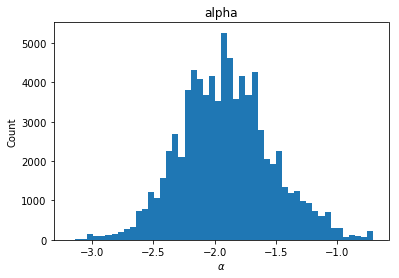

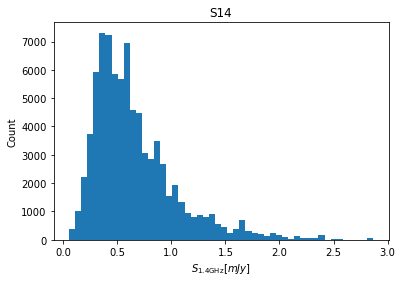

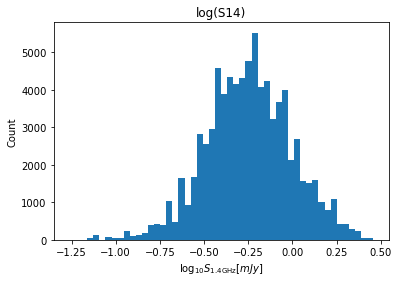

---------
Results for source C1+2
Max Likelihood: 0.005904078163168576
alpha: -1.9090231583298598 +- 0.3736268639890118
MAP alpha: -1.971692087809378
S14: 0.5658245759088548 + 0.4223159783899215 - 0.24182466586606555 mJy
MAP S14: 0.5422682263494261 mJy
(lognormal) S147MHz: 41.44772895106339 + 15.38629384524377 - 11.220865697729852 mJy
(lognormal) S322MHz: 9.320571639997866 + 1.1218252155204933 - 1.0013076914702026 mJy
(lognormal) S608MHz: 2.7804427574574926 + 0.8268478164539284 - 0.6373212735912301 mJy
(lognormal) P14: 0.5878046692437119 + 0.2949951531806827 - 0.1964199856403117 mJy


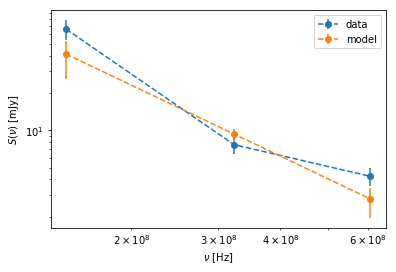

--------
Working on source NW1
Initial L: 0.3347601774327704
Converged in 119686 steps
Acceptance: 2500, rate : 0.02088799024113096


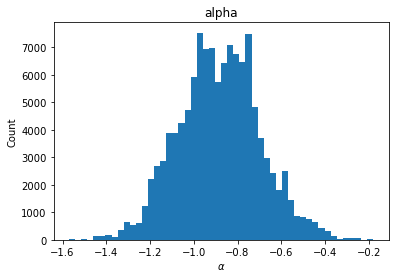

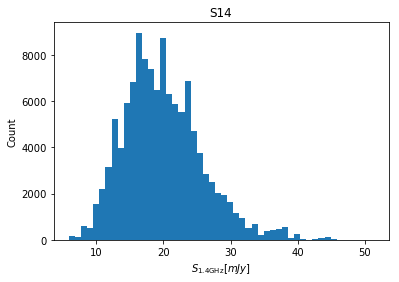

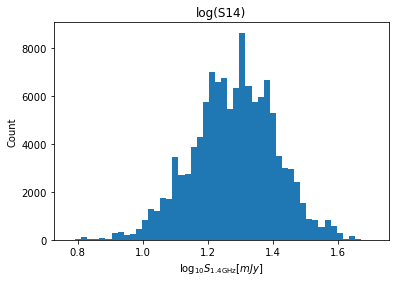

---------
Results for source NW1
Max Likelihood: 0.3722181635246352
alpha: -0.8827406645027855 +- 0.1861021968430736
MAP alpha: -0.8826791278273258
S14: 19.11057104002691 + 6.537639803243344 - 4.871218139052827 mJy
MAP S14: 19.66798835092054 mJy
(lognormal) S147MHz: 139.17912485927206 + 25.49581743151134 - 21.548424479928457 mJy
(lognormal) S322MHz: 69.80863683132709 + 6.872351340785912 - 6.256433183273465 mJy
(lognormal) S608MHz: 39.902023297384446 + 6.6989675816917895 - 5.735980189921392 mJy
(lognormal) P14: 12.95374406010113 + 3.2245965866217716 - 2.5818840011033686 mJy


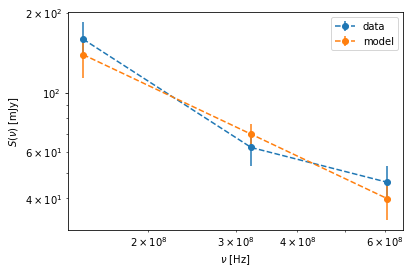

--------
Working on source NW2
Initial L: 0.8955358848465026
Converged in 137402 steps
Acceptance: 2500, rate : 0.018194786102094584


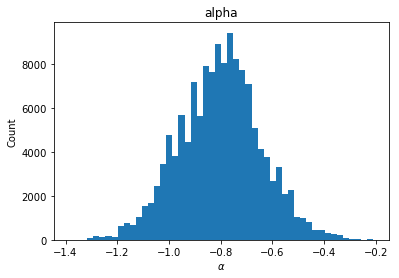

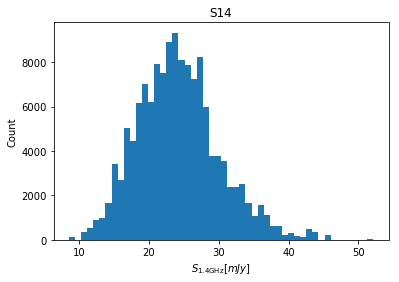

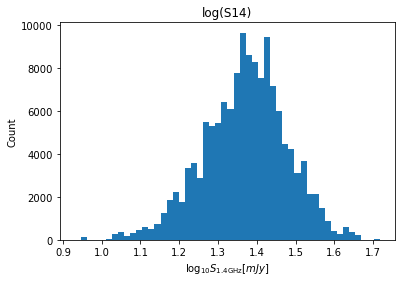

---------
Results for source NW2
Max Likelihood: 0.9960976121971601
alpha: -0.8018349531067345 +- 0.15745844857902708
MAP alpha: -0.8081113454140566
S14: 23.473712511971993 + 6.561495401363398 - 5.128070268221645 mJy
MAP S14: 23.79281222640649 mJy
(lognormal) S147MHz: 142.5115003880094 + 23.998998443178294 - 20.54004582266164 mJy
(lognormal) S322MHz: 76.14653036311284 + 7.343666611702716 - 6.6977292291366695 mJy
(lognormal) S608MHz: 45.81415342146196 + 6.56763985186641 - 5.744187836797906 mJy
(lognormal) P14: 15.384359144396303 + 3.17252214137633 - 2.6301413079525737 mJy


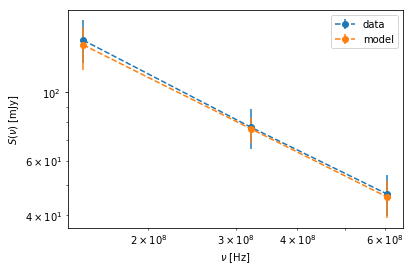

--------
Working on source H
Initial L: 3.402928443054098e-08
Converged in 66138 steps
Acceptance: 2500, rate : 0.037799752033626656


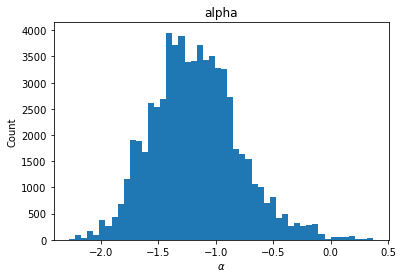

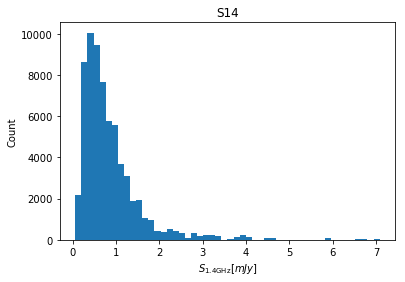

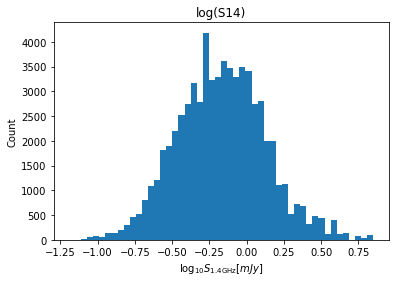

---------
Results for source H
Max Likelihood: 0.9995066674906908
alpha: -1.1786005528218197 +- 0.37895972519789917
MAP alpha: -1.2373849230911258
S14: 0.6791868442876628 + 0.664948570220781 - 0.33599614752134677 mJy
MAP S14: 0.6464264253677809 mJy
(lognormal) S147MHz: 9.622741773338074 + 2.4381904076137157 - 1.945295465946744 mJy
(lognormal) S322MHz: 3.8299932294289607 + 0.7303463961922225 - 0.6133801388033757 mJy
(lognormal) S608MHz: 1.8149659630997423 + 0.8327171079142792 - 0.5708210413478405 mJy
(lognormal) P14: 0.5207103118550568 + 0.3629461316145206 - 0.2138724781290977 mJy


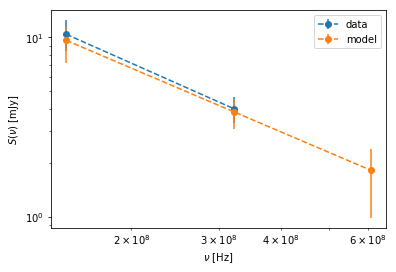

--------
Working on source E
Initial L: 3.5969165800220135e-12
Converged in 126699 steps
Acceptance: 2500, rate : 0.01973180530233072


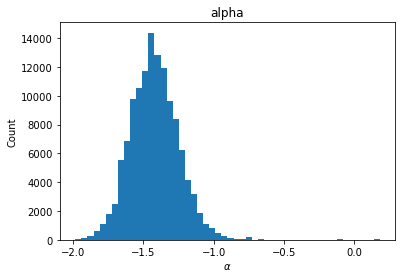

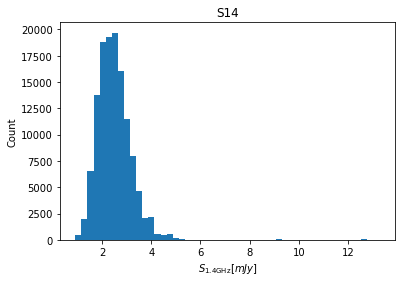

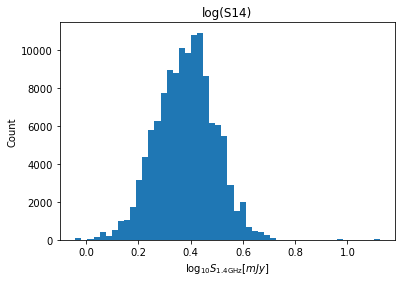

---------
Results for source E
Max Likelihood: 0.6968500048914158
alpha: -1.4217898377019351 +- 0.172771940295331
MAP alpha: -1.4329555670880791
S14: 2.40697277556804 + 0.7082298013696855 - 0.5472163715332186 mJy
MAP S14: 2.441234223166231 mJy
(lognormal) S147MHz: 58.93033100010147 + 11.601680318513722 - 9.693341343109182 mJy
(lognormal) S322MHz: 19.39466672474235 + 2.0341680660110626 - 1.8410712522466142 mJy
(lognormal) S608MHz: 7.878281854049897 + 1.1512001046192406 - 1.0044295936484566 mJy
(lognormal) P14: 2.041799306601102 + 0.4363717419516293 - 0.35953269676743727 mJy


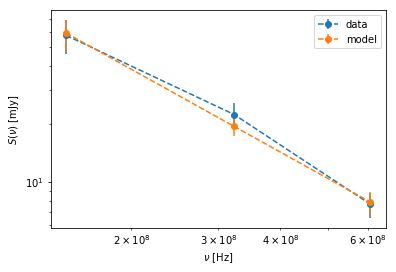

--------
Working on source X1
Initial L: 8.121560875682767e-71
Converged in 89711 steps
Acceptance: 2500, rate : 0.02786726265452397


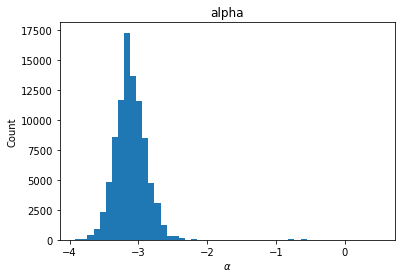

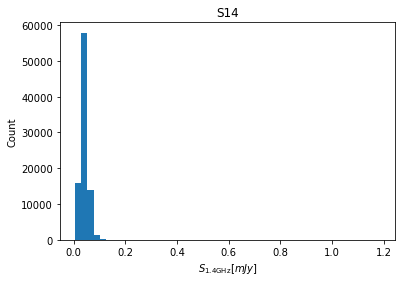

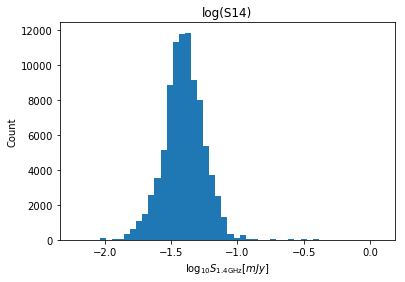

---------
Results for source X1
Max Likelihood: 0.529876756824581
alpha: -3.1083881816275545 +- 0.24648535989547152
MAP alpha: -3.1190209606455555
S14: 0.03956171642028298 + 0.016873739251929025 - 0.011828629348044895 mJy
MAP S14: 0.0402732691766339 mJy
(lognormal) S147MHz: 43.021672038012255 + 13.334425846127473 - 10.179365092783286 mJy
(lognormal) S322MHz: 3.7886050332372676 + 0.6015791612243664 - 0.5191458346965279 mJy
(lognormal) S608MHz: 0.5285757248450405 + 0.10826421880256643 - 0.08985905877790595 mJy
(lognormal) P14: 0.0676981590988359 + 0.02052376285099744 - 0.01574915771596639 mJy


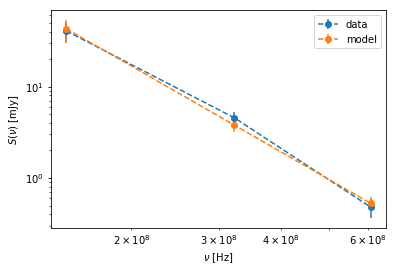

--------
Working on source X2
Initial L: 0.19070752640509775
Converged in 101533 steps
Acceptance: 2500, rate : 0.02462253651522165


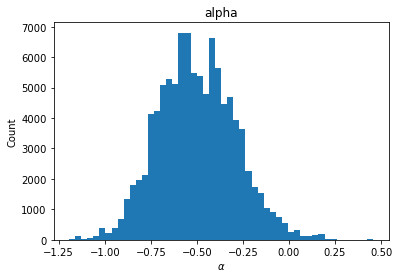

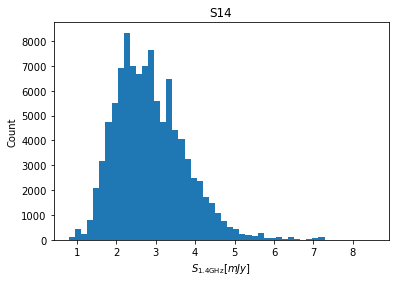

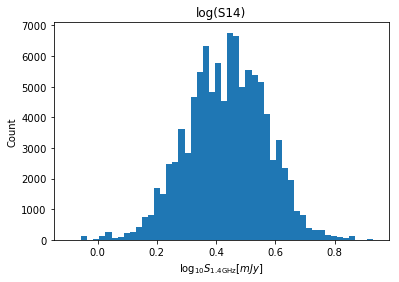

---------
Results for source X2
Max Likelihood: 0.8307046058225167
alpha: -0.5007451926227228 +- 0.21009528119278753
MAP alpha: -0.5336253837582008
S14: 2.7297588791073557 + 0.9791440508329989 - 0.7206516905875198 mJy
MAP S14: 2.6807244176405787 mJy
(lognormal) S147MHz: 8.419271537920075 + 1.982232812589075 - 1.6044752507117401 mJy
(lognormal) S322MHz: 5.692276603996975 + 0.6349135603384513 - 0.571201988751131 mJy
(lognormal) S608MHz: 4.14467030668027 + 0.6881380471949807 - 0.5901548586794227 mJy
(lognormal) P14: 1.5783560468217581 + 0.4009197872460839 - 0.31970994623312277 mJy


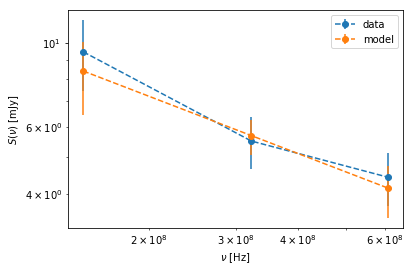

--------
Working on source S
Initial L: 0.15120961322832419
Converged in 94307 steps
Acceptance: 2500, rate : 0.02650916686990361


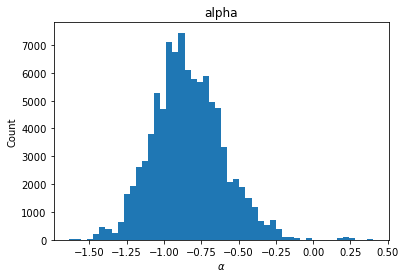

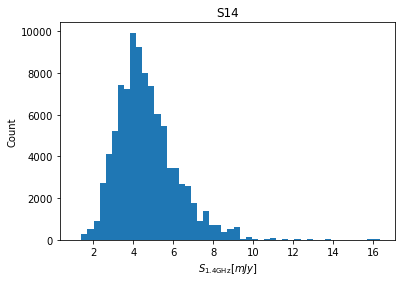

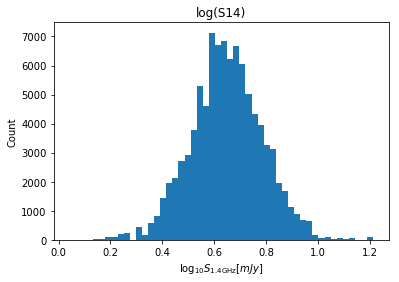

---------
Results for source S
Max Likelihood: 0.9650515789134014
alpha: -0.8384017218679116 +- 0.23609692424535172
MAP alpha: -0.8647699059148145
S14: 4.447535420197641 + 1.650712111527044 - 1.2038869439741227 mJy
MAP S14: 4.421004187743542 mJy
(lognormal) S147MHz: 29.316194647754493 + 8.573074026372296 - 6.633274161302637 mJy
(lognormal) S322MHz: 15.222796520941126 + 1.8842079217564294 - 1.6766765854373364 mJy
(lognormal) S608MHz: 8.9491435901376 + 1.4061878581027383 - 1.2152365300685606 mJy
(lognormal) P14: 2.959750555536288 + 0.749183790024671 - 0.5978528957726619 mJy


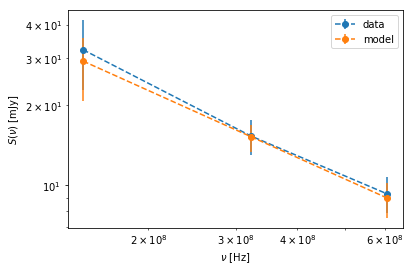

--------


ValueError: Single '}' encountered in format string

In [38]:
'''Compute the posterior estimates of spectral index, S1.4GHz, and P1.4GHz
as well as the posterior estimates of measured fluxes (S_i) using the Metropolis Hastings algorithm.
We assume priors: Gaussian measurments fluxes, uniform spectral index, uniform S1.4, and uniform P1.4.

Detection is defined as 5*sigma_rms. 
The detection mask can be defined to include nondetection measurements (a valid assumption for point sources).

The posterior density is then: prior x Likelihood (with priors described above).
The likelihood is an L2 on spectral index and S1.4 due to the Gaussian prior on observables.

Likelihood = exp(-1/2 * Sum (S_obs - g(alpha_i,S1.4))**2 / (Cd_i + Ct_i))

where S_obs are the measured fluxes
g(alpha_i,S1.4) gives model S_i
Cd_i is the measurement variance S_i
Ct_i is a systematic for g(...) taken to be (0.15*S_obs)**2

assuming z ~ 0.516 +- 0.002 we use the sampling of alpha and S14 to monte carlo compute the mean and variances of 
posterior S_i and P14 in lognormal as suggested by their posterior plots.

We find that the posterior distributions for:
alpha is Gaussian
S1.4 is lognormal
P1.4 is lognormal
S_i is lognormal
'''

import numpy as np
import pylab as plt
if __name__ == '__main__':
    names = ['C1+2','NW1','NW2','H','E','X1','X2','S']
    nu = np.array([147.667e6,322.667e6,608.046e6])
    rms = np.array([1.4e-3,120e-6,90e-6])*1e3
    beams = np.array([43.3*18.9,17.5*9.5,7.2*4.9])*np.pi/4./np.log(2.)
    print("Beams: {} (arcsec^2)".format(beams))
    pixels = np.array([5.25**2,2**2,1.25**2])
    print("px/beam: {} (pixels)".format(beams/pixels))
    print("Uncertainty per px: {} mJy".format(rms*np.sqrt(pixels/beams)))
    #measurement mask
    detectionMask = np.bitwise_not(np.array([[0,0,0],
                  [0,0,0],
                 [0,0,0],
                 [0,0,1],
                 [0,0,0],
                 [0,0,0],
                 [0,0,0],
                 [0,0,0]],dtype=np.bool))
    #measurements
    S = np.array([[  66.034     ,    7.653     ,    4.241     ],
       [ 159.14      ,   62.206     ,   45.998     ],
       [ 147.575     ,   77.056     ,   46.834     ],
       [  10.40630611,    3.98776452,    1.16477836],
       [  57.346     ,   22.343     ,    7.6797    ],
       [  40.672     ,    4.556     ,    0.48076422],
       [   9.45811655,    5.508     ,    4.426     ],
       [  32.342     ,   15.314     ,    9.277     ]],dtype=np.double)
    std_d = np.array([[  6.58200000e+00,   2.94200000e-01,   3.12511200e-01],
       [  7.85100000e+00,   3.86200000e-01,   1.05200000e-01],
       [  8.11100000e+00,   3.54800000e-01,   3.58600000e-01],
       [  1.34408838e+00,   2.55608364e-01,   4.16152840e-01],
       [  7.16500000e+00,   3.11300000e-01,   2.90741019e-04],
       [  7.82100000e+00,   2.09200000e-01,   8.90090959e-02],
       [  1.40738833e+00,   2.27200000e-01,   2.34200000e-01],
       [  8.07500000e+00,   2.77200000e-01,   3.67694221e-01]],dtype=np.double)
    
    
    
    Cd = std_d**2
    CdCt = Cd + (S*0.15)**2
    #previous estimates
    alpha0 = np.array([-2.5501,-0.8804,-0.8458, -1.4624, -0.1102, -0.8988, -0.3312, -0.7236],dtype=np.double)
    S140 = np.array([0.4034,20.5293, 23.2775, 0.113, 13.2874, 1.1842, 3.0169, 6.2674],dtype=np.double)
    P0 = np.array([0.4,13,15,2.1,5.7,0.9,2.3,3.7],dtype=np.double)
    
    def g(alpha,S14,nu):
        '''Forward equation, evaluate model at given nu array'''
        out = S14*(nu/1400e6)**alpha
        return out
    
    def L(Sobs,alpha,S14,nu,CdCt):
        '''Likeihood for alpha and S14'''
        #only as nu_obs
        d = g(alpha,S14,nu)
        return np.exp(-np.sum((Sobs - d)**2/CdCt)/2.)
    
    def P(nu,z,alpha,S14):
        c = 3e8
        h0 = 0.7
        ch = 1.32151838
        q0 = 0.5
        D = ch*z*(1+z*(1-q0)/(np.sqrt(1+2*q0*z) + 1 + q0*z))
        S = S14*(nu/1400e6)
        out = 4*np.pi*S*D**2 / (1+z)**(1+alpha) * 1e26
        return out/1e24
    
    #samples    
    m = len(alpha0)
    #posterior moments
    alpha = np.zeros(m,dtype=np.double)
    std_alpha = np.zeros(m,dtype=np.double)
    S14 = np.zeros(m,dtype=np.double)
    S14u = np.zeros(m,dtype=np.double)
    S14l = np.zeros(m,dtype=np.double)
    P14 = np.zeros(m,dtype=np.double)
    P14u = np.zeros(m,dtype=np.double)
    P14l = np.zeros(m,dtype=np.double)
    idx = 0
    while idx < m:
        #if idx != 5:
        #    idx += 1
        #    continue
        #MH sampling posterior of alpha and S14
        N = int(1e6)
        alpha_ = np.zeros(N,dtype=np.double)
        S14_ = np.zeros(N,dtype=np.double)
        #S_ = np.zeros([N,3],dtype=np.double)
        alpha_[0] = alpha0[idx]
        S14_[0] = S140[idx]
        #S_[0,:] = S[idx,:]
        print("Working on source {}".format(names[idx]))
        mask = detectionMask[idx,:]
        Li = L(S[idx,mask],alpha0[idx],S140[idx],nu[mask],CdCt[idx,mask])
        print("Initial L: {}".format(Li))
        maxL = Li
        alphaMAP = alpha0[idx]
        S14MAP = S140[idx]
        accepted = 0
        binning = 50
        i = 1
        while accepted < binning*binning and i < N:
            #sample priors in uniform steps
            alpha_j = np.random.uniform(low=alpha_[i-1] - 0.5,high=alpha_[i-1] + 0.5)
            S14_j = 10**(np.random.uniform(low = np.log10(S14_[i-1]/100),high=np.log10(S14_[i-1]*100)))
            Lj = L(S[idx,mask],alpha_j,S14_j,nu[mask],CdCt[idx,mask])
            if np.random.uniform() < Lj/Li:
                alpha_[i] = alpha_j
                S14_[i] = S14_j
                #S_[i,mask] = S_j
                Li = Lj
                accepted += 1
            else:
                alpha_[i] = alpha_[i-1]
                S14_[i] = S14_[i-1]
                #S_[i,mask] = S_[i-1,mask]
            if Lj > maxL:
                maxL = Lj
                alphaMAP = alpha_j
                S14MAP = S14_j
            i += 1
        print("Converged in {} steps".format(i))
        print("Acceptance: {}, rate : {}".format(accepted,float(accepted)/i))
        alpha_ = alpha_[:i]
        S14_ = S14_[:i]    
        #integrate out uncertainty unsing MC integration
        logS_int = np.zeros([len(alpha_),3],dtype=np.double)
        logP14_int = np.zeros(len(alpha_),dtype=np.double)
        i = 0 
        while i < len(alpha_):
            logS_int[i,:] = np.log(g(alpha_[i],S14_[i],nu))
            logP14_int[i] = np.log(P(1400e6,np.random.normal(loc=0.516,scale=0.002),alpha_[i],S14_[i]/1e3))
            i += 1
        logS_mu = np.mean(logS_int,axis=0)
        logS_std = np.sqrt(np.mean(logS_int**2,axis=0) - logS_mu**2)
        logP14_mu = np.mean(logP14_int)
        logP14_std = np.sqrt(np.mean(logP14_int**2) - logP14_mu**2)
        S_post_mu = np.exp(logS_mu)
        S_post_up = np.exp(logS_mu + logS_std) - S_post_mu
        S_post_low = S_post_mu - np.exp(logS_mu- logS_std)
        P14_post_mu = np.exp(logP14_mu)
        P14_post_up = np.exp(logP14_mu + logP14_std) - P14_post_mu
        P14_post_low = P14_post_mu - np.exp(logP14_mu- logP14_std)
        P14[idx] = P14_post_mu
        P14u[idx] = P14_post_up
        P14l[idx] = P14_post_low
        alpha[idx] = np.mean(alpha_)
        std_alpha[idx] = np.std(alpha_)
        mu = np.exp(np.mean(np.log(S14_)))
        S14[idx] = mu
        S14u[idx] = np.exp(np.mean(np.log(S14_)) + np.std(np.log(S14_))) - mu
        S14l[idx] = mu - np.exp(np.mean(np.log(S14_)) - np.std(np.log(S14_)))
        plt.hist(alpha_,bins=binning)
        plt.xlabel(r"$\alpha$")
        plt.ylabel(r"Count")
        plt.title("alpha")
        plt.show()
        plt.hist(S14_,bins=binning)
        plt.xlabel(r"$S_{\rm 1.4GHz}[mJy]$")
        plt.ylabel(r"Count")
        plt.title("S14")
        plt.show() 
        plt.hist(np.log10(S14_),bins=binning)
        plt.xlabel(r"$\log_{10}{S_{\rm 1.4GHz}[mJy]}$")
        plt.ylabel(r"Count")
        plt.title("log(S14)")
        plt.show()
        print("---------")
        print("Results for source {}".format(names[idx]))
        print("Max Likelihood: {}".format(maxL))
        print("alpha: {} +- {}".format(alpha[idx],std_alpha[idx]))
        print("MAP alpha: {}".format(alphaMAP))
        print("S14: {} + {} - {} mJy".format(S14[idx],S14u[idx],S14l[idx]))  
        print("MAP S14: {} mJy".format(S14MAP))
        for fi in range(3):
            mu = S_post_mu[fi]
            up = S_post_up[fi]
            low = S_post_low[fi]
            print("(lognormal) S{}MHz: {} + {} - {} mJy".format(int(nu[fi]/1e6),mu,up,low)) 
        print("(lognormal) P14: {} + {} - {} mJy".format(P14_post_mu,
                                         P14_post_up, 
                                         P14_post_low))
        #plot the Gassuan model and data
        plt.errorbar(nu[mask], S[idx,mask], yerr=np.sqrt(CdCt[idx,mask]), fmt='--o',label='data')
        plt.errorbar(nu, S_post_mu, yerr=[S_post_up,S_post_low], fmt='--o',label='model')
        plt.xlabel(r"$\nu$ [Hz]")
        plt.ylabel(r"$S(\nu)$ [mJy]")
        #plt.plot(nu,S_map,label='map')
        #plt.errorbar(nu, S_model, yerr=CdCt[idx,mask], fmt='--o')
        plt.legend()
        plt.yscale('log')
        plt.xscale('log')
        plt.show()
        print("--------")
        idx += 1

In [4]:
S = np.array([[66.034,7.653,2.357 + 1.884],#c12
                  [159.140,62.206,45.998],#nw1
                 [147.575,77.056,46.834],#nw2
                 [350.1*pixels[0]/beams[0],187.8*pixels[1]/beams[1],29.8*pixels[2]/beams[2]],#h
                 [57.346,22.343,(7.619+6.07E-2)],#e
                 [40.672,4.556,12.3*pixels[2]/beams[2]],#x1
                 [318.2*pixels[0]/beams[0],5.508,4.426],#x2
                 [32.342,15.314,3.744+5.533]],dtype=np.double)#s
std_d = np.array([[6.582,2.942E-1,np.sqrt(2.086E-1**2 + 2.327E-1**2)],#c12
                 [7.851,3.862E-1,1.052E-1],#nw1
                 [8.111,3.548E-1,3.586E-1],#nw2
                 [rms[0]*np.sqrt(854.7/beams[0]),rms[1]*np.sqrt(854.7/beams[1]),rms[2]*np.sqrt(854.7/beams[2])],#h
                 [7.165,3.113E-1,np.sqrt(1.845E-4**2 + 2.247E-4**2)],#e
                 [7.821,2.092E-1,rms[2]*np.sqrt(39.1/beams[2])],#x1
                 [rms[0]*np.sqrt(937.1/beams[0]),2.272E-1,2.342E-1],#x2
                 [8.075,2.772E-1,np.sqrt(1.900E-1**2 + 3.148E-1**2)]],dtype=np.double)#s

array([[  6.58200000e+00,   2.94200000e-01,   3.12511200e-01],
       [  7.85100000e+00,   3.86200000e-01,   1.05200000e-01],
       [  8.11100000e+00,   3.54800000e-01,   3.58600000e-01],
       [  1.34408838e+00,   2.55608364e-01,   4.16152840e-01],
       [  7.16500000e+00,   3.11300000e-01,   2.90741019e-04],
       [  7.82100000e+00,   2.09200000e-01,   8.90090959e-02],
       [  1.40738833e+00,   2.27200000e-01,   2.34200000e-01],
       [  8.07500000e+00,   2.77200000e-01,   3.67694221e-01]])

In [3]:
CdCt

array([[  1.41433730e+02,   1.40434284e+00,   5.02350073e-01],
       [  6.31462842e+02,   8.72148452e+01,   4.76169271e+01],
       [  5.55801885e+02,   1.33722494e+02,   4.94806240e+01],
       [  4.24312573e+00,   4.23136618e-01,   2.03709130e-01],
       [  1.25329909e+02,   1.13291248e+01,   1.32700041e+00],
       [  9.83878016e+01,   5.10800200e-01,   1.31231394e-02],
       [  3.99350121e+00,   7.34226280e-01,   4.95612850e-01],
       [  8.87407367e+01,   5.35350825e+00,   2.07161044e+00]])

In [47]:
from math import log10, floor
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

i = 0
while i < len(alpha):
    print(r"{} & ${:.2g} \pm {:.2g}$ & ${:.2g} \pm {:.2g}$ & ${:.2g} \pm {:.2g}$ & ${:.2g} \pm {:.2g}$ & ${:.2g}^{{{:.2g}}}_{{{:.2g}}}$ & ${:.2g}^{{{:.2g}}}_{{{:.2g}}}$\\".format(names[i],
                                                                                              S[i,0],np.sqrt(CdCt[i,0]),
                                                                                             S[i,1],np.sqrt(CdCt[i,1]),
                                                                                             S[i,2],np.sqrt(CdCt[i,2]),
                                                                                             alpha[i],std_alpha[i],
                                                                                             S14[i],S14u[i],S14l[i],
                                                                                             P14[i],P14u[i],P14l[i]))
    i += 1

ValueError: Invalid format specifier